In [80]:
# setup the matplotlib graphics library and configure it to show figures inline in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [81]:
# make qutip available in the rest of the notebook
from qutip import *

In [82]:
# Simulation 1
# In a frame rotating with frequency of the incident field (Rotating Wave approximation)

In [83]:
# Assumptions

# Angle of incidence = 0 (thus, no effect of polarization)
# Incident light is monochromatic

# Considering non-interacting exciton system

In [84]:
# Constants

# h_bar = 1 (convention)
c = 1

# Exciton properties
we = 3.0  * 2 * np.pi        # Frequency (energy) of the exciton in Lab frame
k = 0                        # TMD in-plane momentum
m = 1                        # Mass of exciton

Npr = 5             # Number of cavity fock states for right moving modes
Npl = 5             # Number of cavity fock states for left moving modes
Ne = 5              # Number of exciton fock states

In [85]:
# Essential Operators

r  = tensor(destroy(Npr), qeye(Ne), qeye(Npl))       # Ladder operator of Right propagating field
l  = tensor(qeye(Npr), qeye(Ne), destroy(Npl))       # Ladder operator of Left propagating field

# x = tensor(qeye(Npr), destroy(Ne), qeye(Npl))      # Exciton ladder operator  

In [86]:
def tdep(w_ex, K, t):
    
    r_int = 0
    l_int = 0
    
    r_outt = 0
    l_outt = 0
    
    xt = 0
    
    w_vec = np.linspace(0,10,10)
    dw = w_vec[1] - w_vec[0]
    
    for w in w_vec:
        
        # Rotating frame normalization
        rho = ((w+wp)/c)/np.sqrt((w + wp)**2 - (c*k)**2) # Normalization factor
        
        K =  K                             # Rotating frame normalization

        # Radiative decay of excitons into right(left) moving modes
        gamma = 2 * np.pi * (K ** 2)

        # Free propagator
        G = 1/(gamma - 1j*(w - w_ex))
        
        # Normalizing Right (Left) ladder operator
        r_in = np.sqrt(rho) * r
        l_in = np.sqrt(rho) * l
        
        # Output operators for Right (Left) Propagating field
        r_out = (1 - gamma * G) * r_in - gamma * G * l_in
        l_out = (1 - gamma * G) * l_in - gamma * G * r_in
        
        # Exciton ladder operator
        x = -1j * np.exp(-1j*theta) * np.sqrt(gamma) * G * (r_in + l_in)
        
        # Inverse Fourier Transformation
        
        r_int = r_int + np.exp(-1j*w*t) * r_in * dw
        l_int = l_int + np.exp(-1j*w*t) * l_in * dw
        
        r_outt = r_outt + r_out * np.exp(-1j*w*t) * dw
        l_outt = r_outt + l_out * np.exp(-1j*w*t) * dw

        xt = xt + x * np.exp(-1j*w*t) * dw
    
    return r_int, r_outt, l_int, l_outt, xt

In [87]:
def integral(w_ex, K, theta):
    
    w_vec = np.linspace(0,10,10) * 2 * np.pi
    dw = w_vec[1] - w_vec[0]
    
    H_int = 0
    H_bath = 0
    
    for w in w_vec:
        
        # Rotating frame normalization
        rho = ((w+wp)/c)/np.sqrt((w + wp)**2 - (c*k)**2) # Normalization factor

        K =  K                             # Rotating frame normalization

        # Radiative decay of excitons into right(left) moving modes
        gamma = 2 * np.pi * (K ** 2)

        # Free propagator
        G = 1/(gamma - 1j*(w - w_ex))

        # Essential Operators 

        # Normalizing Right (Left) ladder operator
        r_in = np.sqrt(rho) * r
        l_in = np.sqrt(rho) * l

        # Output operators for Right (Left) Propagating field
        r_out = (1 - gamma * G) * r_in - gamma * G * l_in
        l_out = (1 - gamma * G) * l_in - gamma * G * r_in

        # Exciton ladder operator
        x = -1j * np.exp(-1j*theta) * np.sqrt(gamma) * G * (r_in + l_in)

        # Photon-Exciton Interaction
        H_int = H_int + dw * K * np.exp(1j*theta/2) * x.dag() * ((r_in + l_in + r_out + l_out) + (r_in + l_in + r_out + l_out).dag())

        # Noise Hamiltonian
        H_bath = H_bath + w * (r_in.dag() * r_in + l_in.dag() * l_in + r_out.dag() * r_out + l_out.dag() * l_out) * dw
    
    return H_int, H_bath

In [88]:
# Net Hamiltonian

def Hamiltonian(wp, K, theta):
    
    w_ex = we + (k ** 2)/m - wp  # Frequency (energy) of the exciton in the Rotating frame

    # Rotating frame normalization
    rho = ((w+wp)/c)/np.sqrt((w + wp)**2 - (c*k)**2) # Normalization factor
    
    K =  K                             # Rotating frame normalization
    
    # Radiative decay of excitons into right(left) moving modes
    gamma = 2 * np.pi * (K ** 2)
    
    # Free propagator
    G = 1/(gamma - 1j*(w - w_ex))
    
    # Essential Operators 
    
    # Normalizing Right (Left) ladder operator
    r_in = np.sqrt(rho) * r
    l_in = np.sqrt(rho) * l
    
    # Output operators for Right (Left) Propagating field
    r_out = (1 - gamma * G) * r_in - gamma * G * l_in
    l_out = (1 - gamma * G) * l_in - gamma * G * r_in

    # Exciton ladder operator
    x = -1j * np.exp(-1j*theta) * np.sqrt(gamma) * G * (r_in + l_in)

    # Number operators
    ne = x.dag() * x              # Exciton number operator

    nr_in = r_in.dag() * r_in     # Right--in number operator
    nr_out = r_out.dag() * r_out  # Right--out number operator

    nl_in = l_in.dag() * l_in     # Left--in number operator
    nl_out = l_out.dag() * l_out  # Left--out number operator
    
    # Non-interacting exciton system
    H_tmd = w_ex * x.dag() * x
    
    H_int, H_bath = integral(w_ex, K,theta)
    
    H = H_tmd + H_int + H_bath
    
    return ne, nr_in, nr_out, nl_in, nl_out, r_in, r_out, l_in, l_out, H

In [89]:
w =  0.0  * 2 * np.pi                         # Frequency

wp =  1.0  * 2 * np.pi                         # Frequency

K_vec = np.linspace(0, 1.0, 51) * 2 * np.pi  # Coupling strength vector
theta = np.pi/2                               # Coupling phase

psi_list = []

ne_expt = []
nri_expt = []
nro_expt = []

for K in K_vec:
    
    ne, nr_in, nr_out, nl_in, nl_out, r_in, r_out, l_in, l_out, H = Hamiltonian(wp, K, theta)
    
    # find the groundstate and its energy
    evals, eket = H.eigenstates()
    gket = eket[0]
    
    e = expect(ne, gket)
    ne_expt.append(e)
    
    nri = expect(nr_in, gket)      # Right-in photon occupation probability
    nri_expt.append(nri)
    
    nro = expect(nr_out, gket)
    nro_expt.append(nro)           # Right-out photon occupation probability
    
    # store the ground state
    psi_list.append(gket)

Text(0.5, 1, 'Occupational probability wrt Coupling Strength')

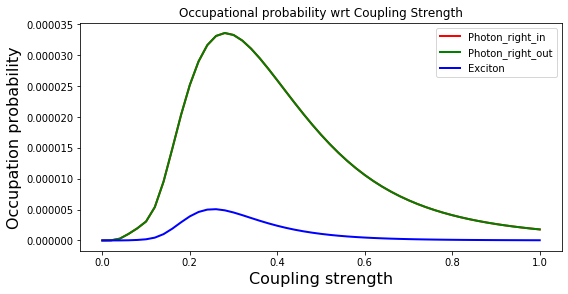

In [90]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(K_vec/(2*np.pi), nri_expt, 'r', linewidth=2, label="Photon_right_in")
axes.plot(K_vec/(2*np.pi), nro_expt, 'g', linewidth=2, label="Photon_right_out")
axes.plot(K_vec/(2*np.pi), ne_expt, 'b', linewidth=2, label="Exciton")
axes.set_ylabel("Occupation probability", fontsize=16)
axes.set_xlabel("Coupling strength", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Occupational probability wrt Coupling Strength")

In [97]:
# Coherent Monochromatic Incident EM field
psi = tensor(coherent(N=5, alpha=1.0), fock(5, 0), fock(5, 0)) 

wp_vec = np.linspace(0, 5.0, 101) * 2 * np.pi   # Frequency vector

# Incident field properties
w = 0.0  * 2 * np.pi  # Frequency (energy) of the incident field

K = 0.25                                       # Coupling strength
theta = np.pi/2                                # Coupling phase 

ne_expt = []
nri_expt = []
nro_expt = []
nlo_expt = []

ri_expt = []
ro_expt = []
li_expt = []
lo_expt = []

for wp in wp_vec:
    
    ne, nr_in, nr_out, nl_in, nl_out, r_in, r_out, l_in, l_out, H = Hamiltonian(wp, K, theta)
    
    e = expect(ne, psi)
    ne_expt.append(e)
    
    nri = expect(nr_in, psi)      # Right-in photon occupation probability
    nri_expt.append(nri)
    
    nro = expect(nr_out, psi)     # Right-out photon occupation probability
    nro_expt.append(nro)          

    nlo = expect(nl_out, psi)     # Left-out photon occupation probability
    nlo_expt.append(nlo)          
    
    lie = expect(l_in, psi)       # Left-in photon expectation value
    li_expt.append(lie)
    
    loe = expect(l_out, psi)      # Left-out photon expectation value
    lo_expt.append(loe)
    
    roe = expect(r_out, psi)      # Right-out photon expectation value
    ro_expt.append(roe)
    
    rie = expect(r_in, psi)       # Right-in photon expectation value
    ri_expt.append(rie)

/home/aakash/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/aakash/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Text(0.5, 1, 'Occupational Probability w.r.t wp')

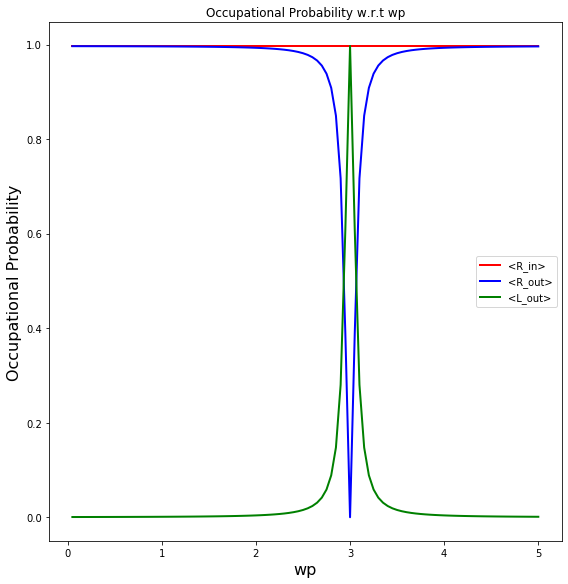

In [98]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))

axes.plot(wp_vec/(2*np.pi), nri_expt, 'r', linewidth=2, label="<R_in>")
axes.plot(wp_vec/(2*np.pi), nro_expt, 'b', linewidth=2, label="<R_out>")
axes.plot(wp_vec/(2*np.pi), nlo_expt, 'g', linewidth=2, label="<L_out>")
axes.set_ylabel("Occupational Probability", fontsize=16)
axes.set_xlabel("wp", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Occupational Probability w.r.t wp")

Text(0.5, 1, 'Occupational Probability w.r.t wp')

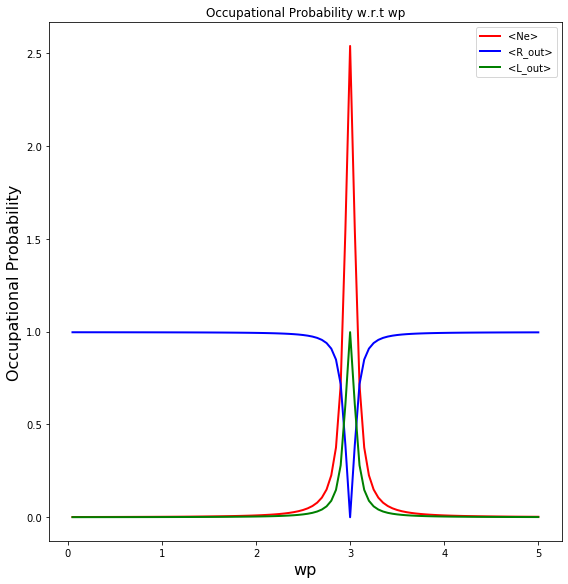

In [99]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))

axes.plot(wp_vec/(2*np.pi), ne_expt, 'r', linewidth=2, label="<Ne>")
axes.plot(wp_vec/(2*np.pi), nro_expt, 'b', linewidth=2, label="<R_out>")
axes.plot(wp_vec/(2*np.pi), nlo_expt, 'g', linewidth=2, label="<L_out>")
axes.set_ylabel("Occupational Probability", fontsize=16)
axes.set_xlabel("wp", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Occupational Probability w.r.t wp")

Text(0.5, 1, 'Expectation value of Coherent Incident field w.r.t wp')

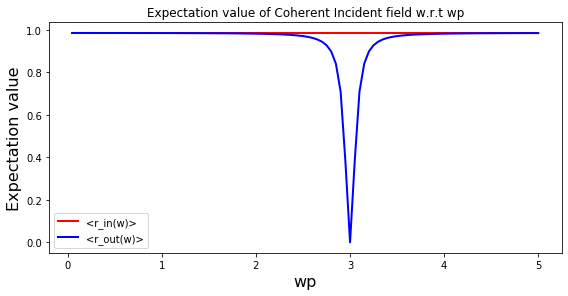

In [100]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(wp_vec/(2*np.pi), ri_expt, 'r', linewidth=2, label="<r_in(w)>")
axes.plot(wp_vec/(2*np.pi), ro_expt, 'b', linewidth=2, label="<r_out(w)>")
axes.set_ylabel("Expectation value", fontsize=16)
axes.set_xlabel("wp", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Expectation value of Coherent Incident field w.r.t wp")

Text(0.5, 1, 'Expectation value of Coherent Incident field w.r.t wp')

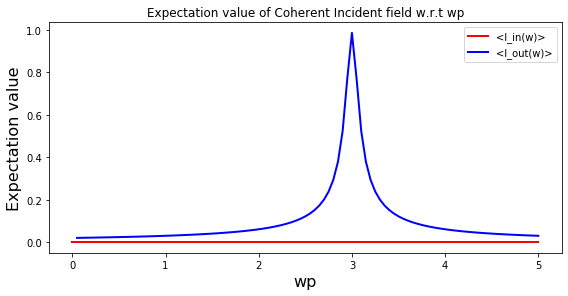

In [101]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(wp_vec/(2*np.pi), li_expt, 'r', linewidth=2, label="<l_in(w)>")
axes.plot(wp_vec/(2*np.pi), np.abs(lo_expt), 'b', linewidth=2, label="<l_out(w)>")
axes.set_ylabel("Expectation value", fontsize=16)
axes.set_xlabel("wp", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Expectation value of Coherent Incident field w.r.t wp")

In [102]:
# Reflection Coefficient 
# RC = gamma * G(w,k)  (k=0 here)
# Can be calculated by taking expectation value of Eq(8)

rc = (np.array(ri_expt) - np.array(ro_expt))/(np.array(ri_expt) + np.array(li_expt))

Text(0.5, 1, ' Reflection Coefficient w.r.t wp')

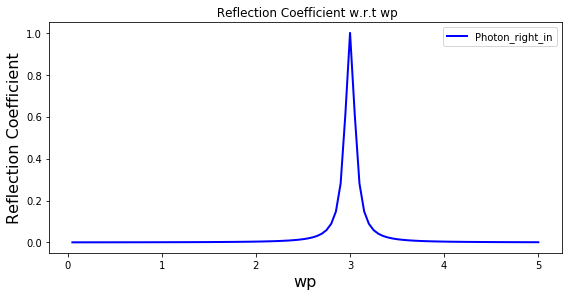

In [103]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(wp_vec/(2*np.pi), rc, 'b', linewidth=2, label="Photon_right_in")
axes.set_ylabel("Reflection Coefficient", fontsize=16)
axes.set_xlabel("wp", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title(" Reflection Coefficient w.r.t wp")

In [113]:
# Coherent Monochromatic Incident EM field
psi0 = tensor(coherent(N=5, alpha=1.0), fock(5, 0), fock(5, 0)) 

w = 2 * 2 * np.pi   # Frequency 
wp = 1 * 2 * np.pi   # Incident coherent Frequency 
w_ex = we + (k ** 2)/m - wp  # Frequency (energy) of the exciton in the Rotating frame

K = 0.25                                       # Coupling strength
theta = np.pi/2                                # Coupling phase 

tlist = np.linspace(0, 4, 751)
co_ops = []
expt_ops = []

ne, nr_in, nr_out, nl_in, nl_out, r_in, r_out, l_in, l_out, H = Hamiltonian(wp, K, theta)

r_int, r_outt, l_int, l_outt, xt = tdep(w_ex, K, tlist[-1])

result = mesolve(H, psi0, tlist, [], [xt.dag()*xt, r_int.dag()*r_int, r_outt.dag()*r_outt, l_outt.dag()*l_outt, r_int, r_outt, l_int, l_outt])

ne_expt = result.expect[0]
nri_expt = result.expect[1]
nro_expt = result.expect[2]
nlo_expt = result.expect[3]

ri_expt = result.expect[4]
ro_expt = result.expect[5]
li_expt = result.expect[6]
lo_expt = result.expect[7]

Text(0.5, 1, 'Occupational Probability of Coherent Incident field w.r.t t')

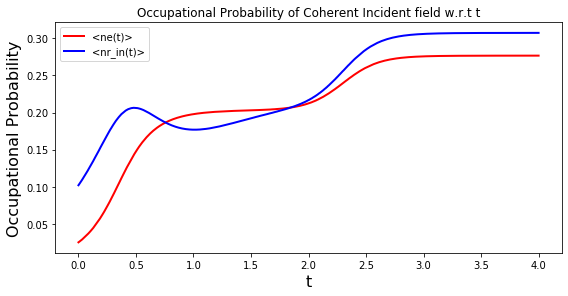

In [114]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist, ne_expt, 'r', linewidth=2, label="<ne(t)>")
axes.plot(tlist, nri_expt, 'b', linewidth=2, label="<nr_in(t)>")
axes.set_ylabel("Occupational Probability", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Occupational Probability of Coherent Incident field w.r.t t")

Text(0.5, 1, 'Occupational Probability of Coherent Incident field w.r.t t')

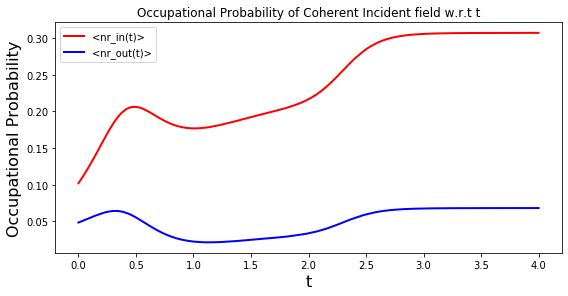

In [115]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist, nri_expt, 'r', linewidth=2, label="<nr_in(t)>")
axes.plot(tlist, nro_expt, 'b', linewidth=2, label="<nr_out(t)>")
axes.set_ylabel("Occupational Probability", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Occupational Probability of Coherent Incident field w.r.t t")

Text(0.5, 1, 'Occupational Probability of Coherent Incident field w.r.t t')

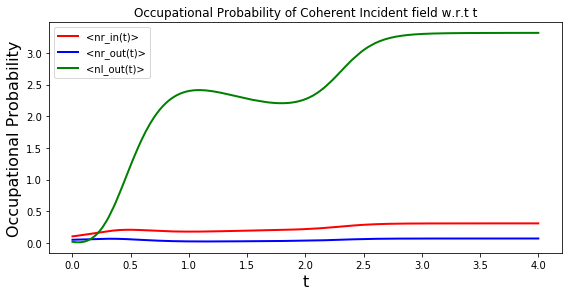

In [116]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist, nri_expt, 'r', linewidth=2, label="<nr_in(t)>")
axes.plot(tlist, nro_expt, 'b', linewidth=2, label="<nr_out(t)>")
axes.plot(tlist, nlo_expt, 'g', linewidth=2, label="<nl_out(t)>")
axes.set_ylabel("Occupational Probability", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Occupational Probability of Coherent Incident field w.r.t t")

Text(0.5, 1, 'Expectation value of Coherent Incident field w.r.t t')

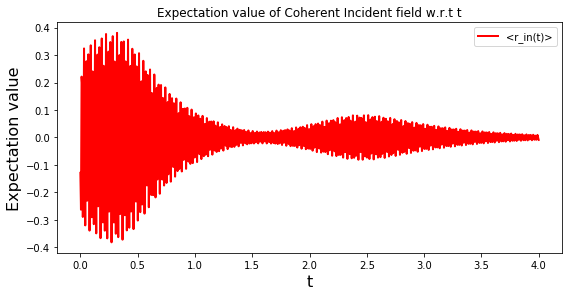

In [117]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist, ri_expt, 'r', linewidth=2, label="<r_in(t)>")
axes.set_ylabel("Expectation value", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Expectation value of Coherent Incident field w.r.t t")

Text(0.5, 1, 'Expectation value of Transmitted field w.r.t t')

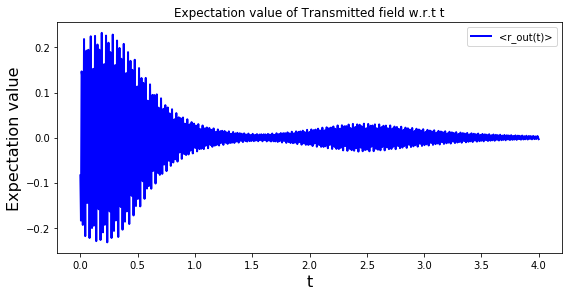

In [118]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist, ro_expt, 'b', linewidth=2, label="<r_out(t)>")
axes.set_ylabel("Expectation value", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Expectation value of Transmitted field w.r.t t")

Text(0.5, 1, 'Expectation value of Reflected field w.r.t t')

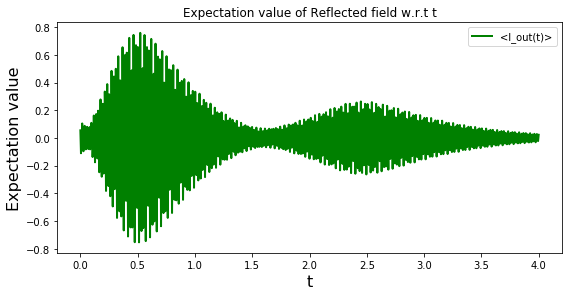

In [119]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist, lo_expt, 'g', linewidth=2, label="<l_out(t)>")
axes.set_ylabel("Expectation value", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Expectation value of Reflected field w.r.t t")

Text(0.5, 1, 'Expectation value w.r.t t')

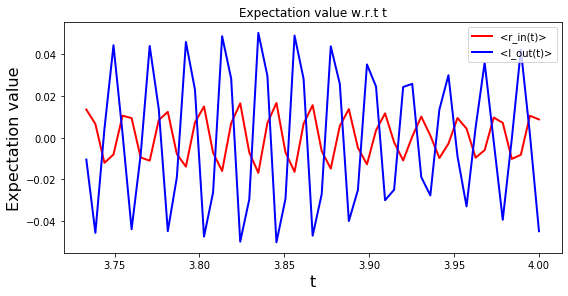

In [156]:
### Just to show the phase of the Reflected and Transmitted propagating field w.r.t Incident field

# Coherent Monochromatic Incident EM field
psi0 = tensor(coherent(N=5, alpha=1.0), fock(5, 0), fock(5, 0)) 

w = 2 * 2 * np.pi   # Frequency 
wp = 1 * 2 * np.pi   # Incident coherent Frequency 
w_ex = we + (k ** 2)/m - wp  # Frequency (energy) of the exciton in the Rotating frame

K = 0.25                                       # Coupling strength
theta = np.pi/2                                # Coupling phase 

# tlist = np.linspace(0, 0.1, 101)

tlist = np.linspace(0, 4, 751)
co_ops = []
expt_ops = []

ne, nr_in, nr_out, nl_in, nl_out, r_in, r_out, l_in, l_out, H = Hamiltonian(wp, K, theta)

r_int, r_outt, l_int, l_outt, xt = tdep(w_ex, K, tlist[-1])

result = mesolve(H, psi0, tlist, [], [xt.dag()*xt, r_int.dag()*r_int, r_outt.dag()*r_outt, l_outt.dag()*l_outt, r_int, r_outt, l_int, l_outt])

ne_expt = result.expect[0]
nri_expt = result.expect[1]
nro_expt = result.expect[2]
nlo_expt = result.expect[3]

ri_expt = result.expect[4]
ro_expt = result.expect[5]
li_expt = result.expect[6]
lo_expt = result.expect[7]

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist[700:], ri_expt[700:], 'r', linewidth=2, label="<r_in(t)>")
axes.plot(tlist[700:], lo_expt[700:], 'b', linewidth=2, label="<l_out(t)>")
axes.set_ylabel("Expectation value", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Expectation value w.r.t t")

Text(0.5, 1, 'Expectation value w.r.t t')

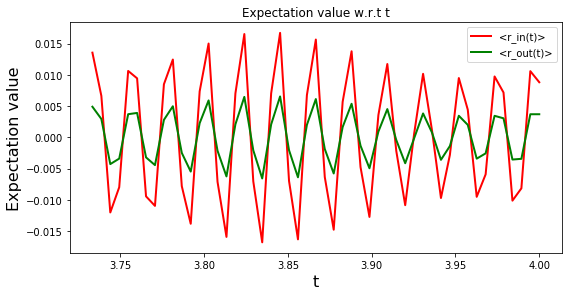

In [157]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist[700:], ri_expt[700:], 'r', linewidth=2, label="<r_in(t)>")
axes.plot(tlist[700:], ro_expt[700:], 'g', linewidth=2, label="<r_out(t)>")
axes.set_ylabel("Expectation value", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Expectation value w.r.t t")

In [158]:
# Coherent Monochromatic Incident EM field
psi0 = tensor(coherent(N=5, alpha=1.0), fock(5, 0), fock(5, 0)) 

w = 2 * 2 * np.pi   # Frequency 
wp = 1 * 2 * np.pi   # Incident coherent Frequency 
w_ex = we + (k ** 2)/m - wp  # Frequency (energy) of the exciton in the Rotating frame

K = 0.25                                       # Coupling strength
theta = np.pi/2                                # Coupling phase 

tlist = np.linspace(0, 4, 751)
co_ops = []
expt_ops = []

ne, nr_in, nr_out, nl_in, nl_out, r_in, r_out, l_in, l_out, H = Hamiltonian(wp, K, theta)

result = mesolve(H, psi0, tlist, [], [ne, nr_in, nr_out, nl_out, r_in , r_out, l_in, l_out])

ne_expt = result.expect[0]
nri_expt = result.expect[1]
nro_expt = result.expect[2]
nlo_expt = result.expect[3]

ri_expt = result.expect[4]
ro_expt = result.expect[5]
li_expt = result.expect[6]
lo_expt = result.expect[7]

Text(0.5, 1, 'Occupational Probability w.r.t t')

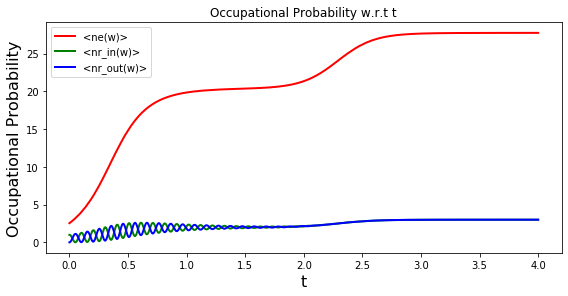

In [159]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist, ne_expt, 'r', linewidth=2, label="<ne(w)>")
axes.plot(tlist, nri_expt, 'g', linewidth=2, label="<nr_in(w)>")
axes.plot(tlist, nro_expt, 'b', linewidth=2, label="<nr_out(w)>")
axes.set_ylabel("Occupational Probability", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Occupational Probability w.r.t t")

Text(0.5, 1, 'Occupational Probability w.r.t t')

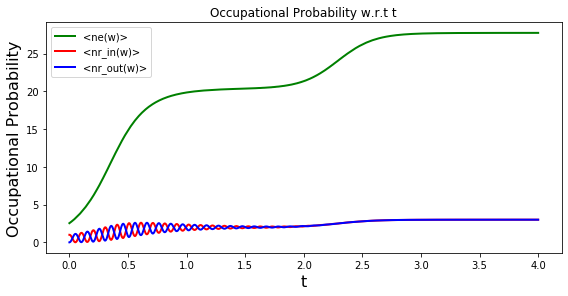

In [160]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist, ne_expt, 'g', linewidth=2, label="<ne(w)>")
axes.plot(tlist, nri_expt, 'r', linewidth=2, label="<nr_in(w)>")
axes.plot(tlist, nro_expt, 'b', linewidth=2, label="<nr_out(w)>")
axes.set_ylabel("Occupational Probability", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Occupational Probability w.r.t t")

Text(0.5, 1, 'Occupational Probability w.r.t t')

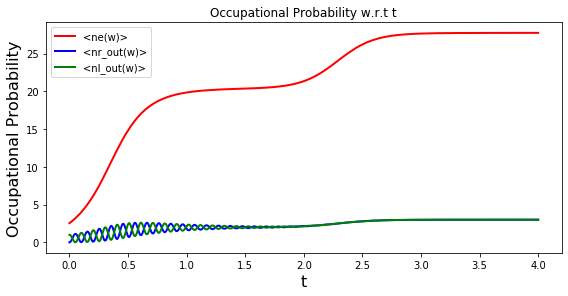

In [161]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist, ne_expt, 'r', linewidth=2, label="<ne(w)>")
axes.plot(tlist, nro_expt, 'b', linewidth=2, label="<nr_out(w)>")
axes.plot(tlist, nlo_expt, 'g', linewidth=2, label="<nl_out(w)>")
axes.set_ylabel("Occupational Probability", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Occupational Probability w.r.t t")

Text(0.5, 1, 'Expectation value of Coherent Incident field w.r.t t')

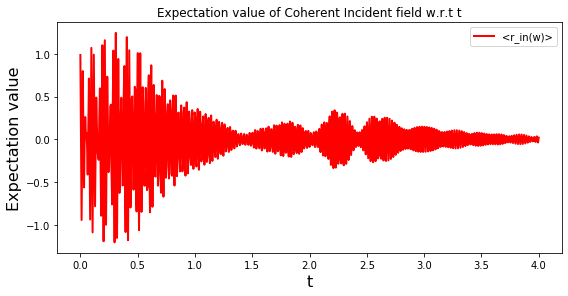

In [162]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist, ri_expt, 'r', linewidth=2, label="<r_in(w)>")
axes.set_ylabel("Expectation value", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Expectation value of Coherent Incident field w.r.t t")

Text(0.5, 1, 'Expectation value of Transmitted field w.r.t t')

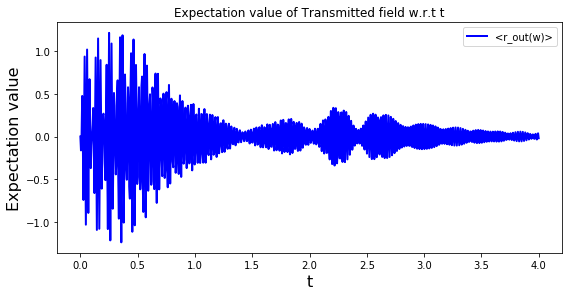

In [163]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist, ro_expt, 'b', linewidth=2, label="<r_out(w)>")
axes.set_ylabel("Expectation value", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Expectation value of Transmitted field w.r.t t")

Text(0.5, 1, 'Expectation value of Reflected field w.r.t t')

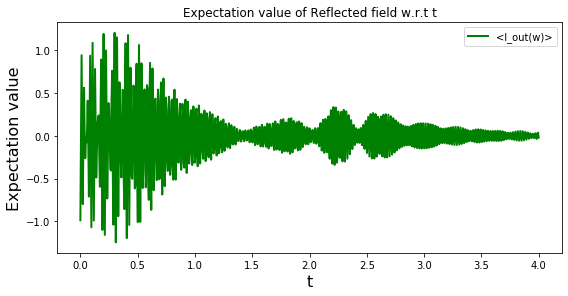

In [164]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist, lo_expt, 'g', linewidth=2, label="<l_out(w)>")
axes.set_ylabel("Expectation value", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Expectation value of Reflected field w.r.t t")

Text(0.5, 1, 'Expectation value of w.r.t t')

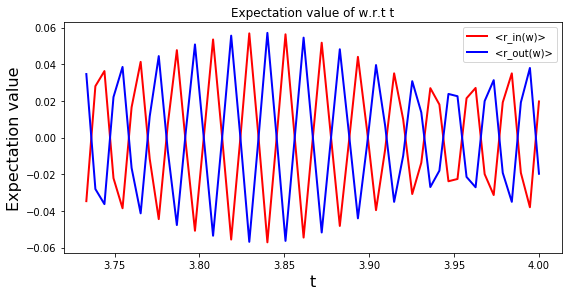

In [165]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist[700:], ri_expt[700:], 'r', linewidth=2, label="<r_in(w)>")
axes.plot(tlist[700:], ro_expt[700:], 'b', linewidth=2, label="<r_out(w)>")
axes.set_ylabel("Expectation value", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Expectation value of w.r.t t")

Text(0.5, 1, 'Expectation value of w.r.t t')

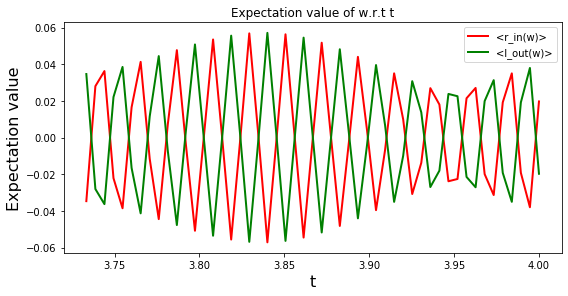

In [166]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist[700:], ri_expt[700:], 'r', linewidth=2, label="<r_in(w)>")
axes.plot(tlist[700:], lo_expt[700:], 'g', linewidth=2, label="<l_out(w)>")
axes.set_ylabel("Expectation value", fontsize=16)
axes.set_xlabel("t", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Expectation value of w.r.t t")

Text(0.5, 1, 'Reflection Coefficient w.r.t t')

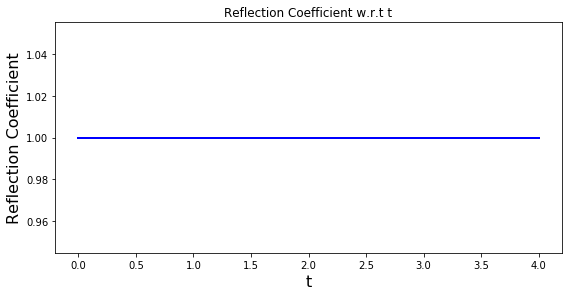

In [167]:
### Just to show the change of Reflection coefficient w.r.t T (it shouldn't)

# Reflection Coefficient 
# RC = gamma * G(w,k)  (k=0 here)
# Can be calculated by taking expectation value of Eq(8)

rc = (np.array(ri_expt) - np.array(ro_expt))/(np.array(ri_expt) + np.array(li_expt))


fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(tlist, rc, 'b', linewidth=2)
axes.set_ylabel("Reflection Coefficient", fontsize=16)
axes.set_xlabel("t", fontsize=16)

fig.tight_layout()
axes.set_title("Reflection Coefficient w.r.t t")

In [132]:
# Coherent Monochromatic Incident EM field
psi = tensor(coherent(N=5, alpha=1.0), fock(5, 0), fock(5, 0)) 

w = 0 * 2 * np.pi   # Frequency vector
wp = 1 * 2 * np.pi   # Incident coherent Frequency 
w_ex = we + (k ** 2)/m - wp  # Frequency (energy) of the exciton in the Rotating frame

K_vec = np.linspace(0, 1.0, 51) * 2 * np.pi    # Coupling strength vector
theta = np.pi/2                                # Coupling phase 

ne_expt = []
nri_expt = []
nro_expt = []
nlo_expt = []

ri_expt = []
ro_expt = []
li_expt = []
lo_expt = []

for K in K_vec:
    
    ne, nr_in, nr_out, nl_in, nl_out, r_in, r_out, l_in, l_out, H = Hamiltonian(wp, K, theta)
    
    e = expect(ne, psi)
    ne_expt.append(e)
    
    nri = expect(nr_in, psi)      # Right-in photon occupation probability
    nri_expt.append(nri)
    
    nro = expect(nr_out, psi)     # Right-out photon occupation probability
    nro_expt.append(nro)          

    nlo = expect(nl_out, psi)     # Left-out photon occupation probability
    nlo_expt.append(nlo)          
    
    lie = expect(l_in, psi)       # Left-in photon expectation value
    li_expt.append(lie)
    
    loe = expect(l_out, psi)      # Left-out photon expectation value
    lo_expt.append(loe)
    
    roe = expect(r_out, psi)      # Right-out photon expectation value
    ro_expt.append(roe)
    
    rie = expect(r_in, psi)       # Right-in photon expectation value
    ri_expt.append(rie)

In [133]:
# Reflection Coefficient 
# RC = gamma * G(w,k)  (k=0 here)
# Can be calculated by taking expectation value of Eq(8)

rc = (np.array(ri_expt) - np.array(ro_expt))/(np.array(ri_expt) + np.array(li_expt))

Text(0.5, 1, 'Reflection Coefficient field w.r.t K')

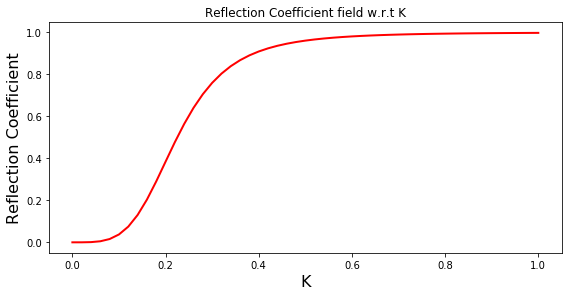

In [134]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(K_vec/(2*np.pi), rc, 'r', linewidth=2)
axes.set_ylabel("Reflection Coefficient", fontsize=16)
axes.set_xlabel("K", fontsize=16)

fig.tight_layout()
axes.set_title("Reflection Coefficient field w.r.t K")

Text(0.5, 1, 'Expectation value of Coherent Incident field w.r.t K')

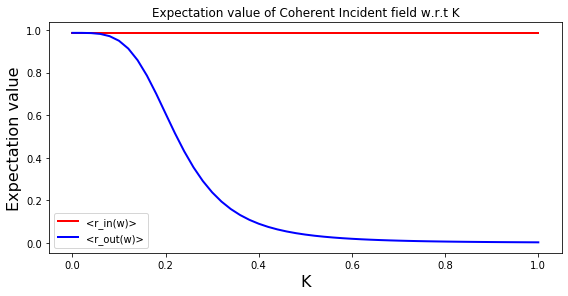

In [135]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,4))

axes.plot(K_vec/(2*np.pi), ri_expt, 'r', linewidth=2, label="<r_in(w)>")
axes.plot(K_vec/(2*np.pi), ro_expt, 'b', linewidth=2, label="<r_out(w)>")
axes.set_ylabel("Expectation value", fontsize=16)
axes.set_xlabel("K", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()
axes.set_title("Expectation value of Coherent Incident field w.r.t K")